In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

proj_path = Path('.').resolve()
exp_name = 'test_exp2_25'  # 'test_exp1', 'test_exp2_[25/50/75]'
test_cols = ['c_low', 'c_mid', 'c_high', 't_1',  't_2',  't_3+']
eval_cols = ['score', 's_sel', 's_cond', 's_agg', 's_nest', 's_oth']
df_train = pd.read_csv(proj_path / 'data' / 'split_in_domain' / 'spider_bo_desc_train.csv')
df_train_origin = pd.read_csv(proj_path / 'data' / 'split_in_domain' / 'train_origin.csv')
df = pd.read_csv(proj_path / 'experiments' / 'bo_evals' / f'all_{exp_name}.csv')

# check hint
no_hint_str = 'Descriptions and Virtual Tables:\n{}\n'
hint_cols = [f'{test_col}_hint' for test_col in test_cols]
df_hint = df.loc[:, hint_cols].apply(lambda x: x != no_hint_str)
df_hint.rename(columns={col: f'{col}_exist' for col in hint_cols}, inplace=True)
df = pd.concat([df, df_hint], axis=1)
df = df.dropna()

print(f'Number of Train(BOs) {len(df_train)} | Number of Test queries {len(df)}')

Number of Train(BOs) 3489 | Number of Test queries 2126


In [5]:
df_train.groupby(['cate_len_tbls']).size()

cate_len_tbls
1     2029
2     1110
3+     350
dtype: int64

In [6]:
df_train.groupby(['cate_gold_c']).size()

cate_gold_c
high     899
low     1553
mid     1037
dtype: int64

# Execution Accuracy

In [7]:
# number of samples
len(df) + len(df_train)

5615

In [8]:
df_baseline = (df['score'].agg(['sum', 'count']) + df_train['score'].agg(['sum', 'count']))
df_baseline['mean'] = (df_baseline['sum'] / df_baseline['count'] * 100).round(2)
df_baseline

sum      3489.00
count    5615.00
mean       62.14
Name: score, dtype: float64

In [9]:
score_cols = [f'{test_col}_score' for test_col in test_cols]
df_overall = df.loc[:, score_cols].agg(['sum', 'count']).T
df_overall += np.repeat(np.array([len(df_train)]), 2)[None, :]
df_overall['ex_acc'] = (df_overall['sum'] * 100 / df_overall['count']).round(2)
df_overall['sum'] = df_overall['sum'].astype(int)
df_overall['count'] = df_overall['count'].astype(int)
df_overall

,sum,count,ex_acc
c_low_score,3714,5615,66.14
c_mid_score,3736,5615,66.54
c_high_score,3795,5615,67.59
t_1_score,3692,5615,65.75
t_2_score,3803,5615,67.73
t_3+_score,3672,5615,65.40


In [10]:
df.groupby(['cate_gold_c'])['score'].agg(['sum', 'count'])

,sum,count
cate_gold_c,,
high,0,924
low,0,521
mid,0,681


In [11]:
df_baseline_c = (df.groupby(['cate_gold_c'])['score'].agg(['sum', 'count']) + df_train.groupby(['cate_gold_c'])['score'].agg(['sum', 'count']))
df_baseline_c['ex_acc'] = (df_baseline_c['sum'] / df_baseline_c['count']*100).round(2)
df_baseline_c.reindex(['low', 'mid', 'high'])

,sum,count,ex_acc
cate_gold_c,,,
low,1553,2074,74.88
mid,1037,1718,60.36
high,899,1823,49.31


In [12]:
df_baseline_t = (df.groupby(['cate_len_tbls'])['score'].agg(['sum', 'count']) + df_train.groupby(['cate_len_tbls'])['score'].agg(['sum', 'count']))
df_baseline_t['ex_acc'] = (df_baseline_t['sum'] / df_baseline_t['count']*100).round(2)
df_baseline_t

,sum,count,ex_acc
cate_len_tbls,,,
1,2029,3025,67.07
2,1110,2014,55.11
3+,350,576,60.76


In [13]:
def get_acc(df: pd.DataFrame, df_train: pd.DataFrame, key_column: list[str], key_test_cols: list[str], key_sort_indexs: list[str]):
    cols = [f'{test_col}_score' for test_col in key_test_cols]
    df_c = df.groupby([key_column])[cols].agg(['count', 'sum']).astype(np.int64)
    for c in cols:
        df_c[c] = df_c[c] + df_train.groupby([key_column]).size().values[:, None]
    df_acc = (df_c.xs('sum', axis=1, level=1) / df_c.xs('count', axis=1, level=1) * 100).round(2)
    df_acc = df_acc.reindex(key_sort_indexs)
    return df_acc.T

key_column = 'cate_gold_c'
key_test_cols = ['c_low', 'c_mid', 'c_high']
key_sort_indexs = ['low', 'mid', 'high']
df_acc_c = get_acc(df, df_train, key_column, key_test_cols, key_sort_indexs)
df_acc_c = pd.concat([df_acc_c, df_overall.iloc[:3][['ex_acc']].rename(columns={'ex_acc': 'overall'})], axis=1)
df_acc_c

,low,mid,high,overall
c_low_score,78.93,63.74,53.87,66.14
c_mid_score,77.82,65.77,54.42,66.54
c_high_score,78.54,65.08,57.49,67.59


In [14]:
key_column = 'cate_len_tbls'
key_test_cols = ['t_1', 't_2',  't_3+']
key_sort_indexs = ['1', '2', '3+']
df_acc_t = get_acc(df, df_train, key_column, key_test_cols, key_sort_indexs)
df_acc_t = pd.concat([df_acc_t, df_overall.iloc[3:][['ex_acc']].rename(columns={'ex_acc': 'overall'})], axis=1)
df_acc_t

,1,2,3+,overall
t_1_score,70.71,58.64,64.58,65.75
t_2_score,70.02,64.55,66.84,67.73
t_3+_score,68.99,59.29,67.88,65.40


## Gropy by hints

In [57]:
# from itertools import pairwise
# groupby hints
hint_exist_cols = [f'{test_col}_hint_exist' for test_col in test_cols]
score_cols = [f'{test_col}_score' for test_col in test_cols]
dfs = []
for c1, c2 in zip(hint_exist_cols, score_cols):
    test_col = '_'.join(c2.split('_', 2)[:2])
    df_temp = df.groupby([c1])[c2].agg(['sum', 'count']).astype(np.int64)
    acc = (df_temp['sum'] / df_temp['count'] * 100).round(2)
    acc.rename(f'{test_col}_delta_improvement', inplace=True)
    df_temp = df_temp.reset_index()
    df_temp[acc.name] = acc
    # df_temp[f'{test_col}_delta_improvement'] = acc
    # df_temp.rename(columns={'count': f'{test_col}_count', 'sum': f'{test_col}_sum'}, inplace=True)
    dfs.append(df_temp)
    
df_hint_exist = pd.concat(dfs, axis=1).T
df_hint_exist

,0,1
c_low_hint_exist,False,True
sum,77,148
count,1221,905
c_low_delta_improvement,6.31,16.35
c_mid_hint_exist,False,True
sum,58,189
count,994,1132
c_mid_delta_improvement,5.84,16.7
c_high_hint_exist,False,True
sum,42,264


In [63]:
exp_names = ['test_exp2_25', 'test_exp2_50', 'test_exp2_75', 'test_exp1']  # 'test_exp1', 'test_exp2_[25/50/75]'
test_cols = ['c_low', 'c_mid', 'c_high', 't_1',  't_2',  't_3+']
eval_cols = ['score', 's_sel', 's_cond', 's_agg', 's_nest', 's_oth']
hint_exist_cols = [f'{test_col}_hint_exist' for test_col in test_cols]
score_cols = [f'{test_col}_score' for test_col in test_cols]

dfs2 = []
for exp_name in exp_names:
    percentage = exp_name.split('_')[-1] if len(exp_name.split('_')) > 2 else '100'
    df_train = pd.read_csv(proj_path / 'data' / 'split_in_domain' / 'spider_bo_desc_train.csv')
    df_train_origin = pd.read_csv(proj_path / 'data' / 'split_in_domain' / 'train_origin.csv')
    df = pd.read_csv(proj_path / 'experiments' / 'bo_evals' / f'all_{exp_name}.csv')

    # check hint
    no_hint_str = 'Descriptions and Virtual Tables:\n{}\n'
    hint_cols = [f'{test_col}_hint' for test_col in test_cols]
    df_hint = df.loc[:, hint_cols].apply(lambda x: x != no_hint_str)
    df_hint.rename(columns={col: f'{col}_exist' for col in hint_cols}, inplace=True)
    df = pd.concat([df, df_hint], axis=1)
    df = df.dropna()


    dfs = []
    for c1, c2 in zip(hint_exist_cols, score_cols):
        test_col = '_'.join(c2.split('_', 2)[:2])
        df_temp = df.groupby([c1])[c2].agg(['sum', 'count']).astype(np.int64)
        acc = (df_temp['sum'] / df_temp['count'] * 100).round(2)
        acc.rename(f'{test_col}_delta_improvement', inplace=True)
        df_temp = df_temp.reset_index()
        df_temp[acc.name] = acc
        # df_temp[f'{test_col}_delta_improvement'] = acc
        # df_temp.rename(columns={'count': f'{test_col}_count', 'sum': f'{test_col}_sum'}, inplace=True)
        dfs.append(df_temp)
        
    df_hint_exist = pd.concat(dfs, axis=1).T
    df_hint_exist.rename(columns={0: f'F-{percentage}%', 1: f'T-{percentage}%'}, inplace=True)
    dfs2.append(df_hint_exist)

df_hint_exist = pd.concat(dfs2, axis=1)

In [64]:
df_hint_exist

,F-25%,T-25%,F-50%,T-50%,F-75%,T-75%,F-100%,T-100%
c_low_hint_exist,False,True,False,True,False,True,False,True
sum,77,148,50,208,49,351,21,313
count,1221,905,796,1325,651,1466,324,1661
c_low_delta_improvement,6.31,16.35,6.28,15.7,7.53,23.94,6.48,18.84
c_mid_hint_exist,False,True,False,True,False,True,False,True
sum,58,189,36,269,156,318,20,357
count,994,1132,590,1531,576,1541,369,1616
c_mid_delta_improvement,5.84,16.7,6.1,17.57,27.08,20.64,5.42,22.09
c_high_hint_exist,False,True,False,True,False,True,False,True
sum,42,264,36,305,25,471,22,376


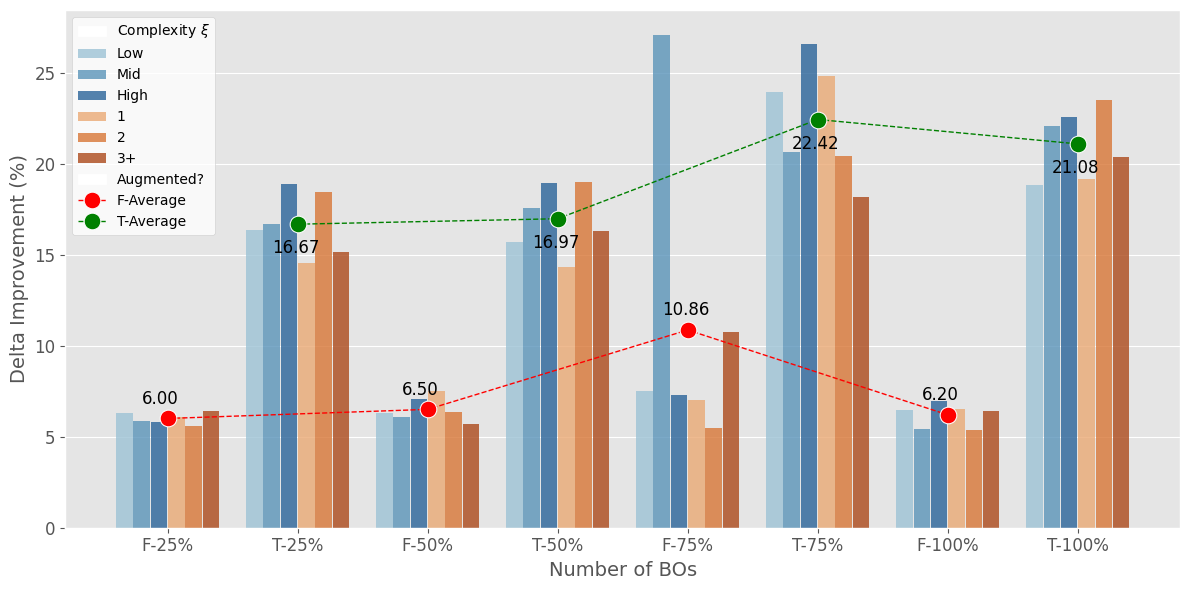

In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('ggplot')
# data from upper table
data = {
    'Delta Improvement': ['Low', 'Mid', 'High', '1', '2', '3+'],
    'F-25%': [6.31, 5.84, 5.79, 6.07, 5.58, 6.41],
    'F-50%': [6.28, 6.1, 7.06, 7.51, 6.35, 5.67],
    'F-75%': [7.53, 27.08, 7.29, 7.0, 5.5, 10.76],
    'F-100%': [6.48, 5.42, 6.94, 6.54, 5.39, 6.43],
    'T-25%': [16.35, 16.7, 18.86, 14.53, 18.46, 15.14],
    'T-50%': [15.7, 17.57, 18.93, 14.31, 18.99, 16.31],
    'T-75%': [23.94, 20.64, 26.55, 24.8, 20.42, 18.19],
    'T-100%': [18.84, 22.09, 22.54, 19.17, 23.49, 20.37]
}
tcols = [f'T-{i}%' for i in [25, 50, 75, 100]]
fcols = [f'F-{i}%' for i in [25, 50, 75, 100]]
df = pd.DataFrame(data)

# Melt the DataFrame to long format for seaborn
df_melted = pd.melt(df, id_vars='Delta Improvement', value_vars=['F-25%', 'T-25%', 'F-50%', 'T-50%', 'F-75%', 'T-75%', 'F-100%', 'T-100%'], 
                    var_name='Condition', value_name='Value')

# Creating a bar plot
n = 4
palette = sns.color_palette('Blues', n)[1:] + sns.color_palette('Oranges', n)[1:]
plt.figure(figsize=(12, 6), dpi=100)
pb = sns.barplot(x='Condition', y='Value', hue='Delta Improvement', data=df_melted, gap=0.05, palette=palette, alpha=0.8)

df_avg = df.set_index('Delta Improvement').mean().round(2)
pl1 = sns.lineplot(df_avg.loc[fcols], label='F-Average', color='red', marker='o', linestyle='dashed', linewidth=1, markersize=12)
pl2 = sns.lineplot(df_avg.loc[tcols], label='T-Average', color='green', marker='o', linestyle='dashed', linewidth=1, markersize=12)
# plot the number
for i, value in enumerate(df_avg.loc[fcols]):
    pb.text(i*2-0.2, value+0.8, f'{value:.2f}', fontsize=12, color='black')

for i, value in enumerate(df_avg.loc[tcols]):
    pb.text((1+i*2)-0.2, value-1.6, f'{value:.2f}', fontsize=12, color='black')

# plt.title('Comparison of Execution Acc. Improvement by Retrieval Augmented Generation and the number of BOs')
plt.ylabel('Delta Improvement (%)', fontsize=14)
plt.xlabel('Number of BOs', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
title_proxy = Rectangle((0,0), 0, 0, color='w')
handles, labels = plt.gca().get_legend_handles_labels()
lgd = plt.legend([title_proxy]+handles[:6]+[title_proxy]+handles[6:], 
                 ['Complexity $\\xi$']+labels[:6]+['Augmented?']+labels[6:], loc='upper left')
lgd.get_frame().set_facecolor('white')

plt.savefig(proj_path / 'num_bo.pdf', bbox_inches='tight', dpi='figure', pad_inches=0.05)
plt.show()
